## Importing Necessary Dependancies

In [23]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import vgg19
from tensorflow.keras.applications.vgg19 import preprocess_input
import tensorflow_hub as hub
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

## Loading Pre-Trained Model

In [17]:
model = hub.load("https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2")


In [18]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    return img


In [24]:
def load_and_process_img(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [9]:
content_image = load_image("C:\\Users\\muham\\Desktop\\Images\\106310992.png")
style_image = load_image("C:\\Users\\muham\\Desktop\\Images\\park.jpeg")

## Visualizing

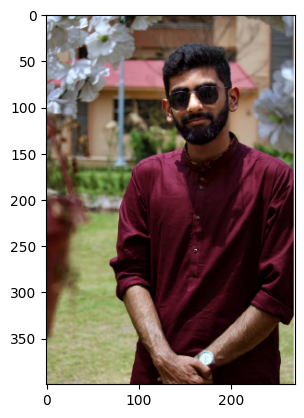

TensorShape([1, 400, 269, 3])

In [14]:
plt.imshow(np.squeeze(content_image))
plt.show()
content_image.shape

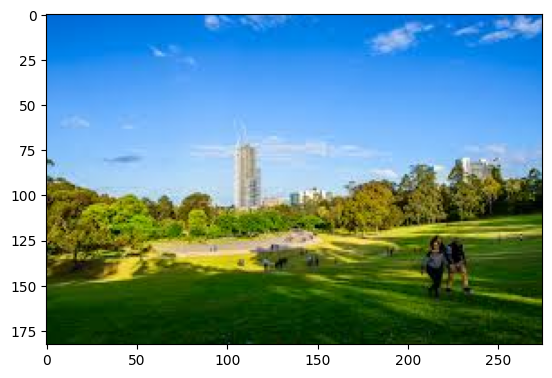

TensorShape([1, 183, 275, 3])

In [13]:
plt.imshow(np.squeeze(style_image))
plt.show()
style_image.shape

In [25]:

content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Load the VGG19 model
model = vgg19(include_top=False, weights='imagenet')

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers if layer.name in content_layers + style_layers])

feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 84s 1us/step


In [33]:
def content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def style_loss(base_style, gram_target):
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))
img_nrows = 400
img_ncols = 400
def total_variation_loss(image):
    x_var = image[:, :img_nrows-1, :img_ncols-1, :] - image[:, 1:, :img_ncols-1, :]
    y_var = image[:, :img_nrows-1, :img_ncols-1, :] - image[:, :img_nrows-1, 1:, :]
    return tf.reduce_sum(tf.abs(x_var)) + tf.reduce_sum(tf.abs(y_var))

def compute_loss(image, output):
    content_weight = 1e3
    style_weight = 1e-2
    total_variation_weight = 30

    base_content = output['block5_conv2']
    gram_style = [gram_matrix(output[name]) for name in style_layers]

    current_features = feature_extractor(image)
    current_content = current_features['block5_conv2']
    current_style = [gram_matrix(current_features[name]) for name in style_layers]

    content_loss_value = content_weight * content_loss(base_content, current_content)
    style_loss_value = style_weight * tf.add_n([style_loss(base_style, current_style) for base_style, current_style in zip(gram_style, current_style)])
    total_variation_loss_value = total_variation_weight * total_variation_loss(image)

    total_loss = content_loss_value + style_loss_value + total_variation_loss_value
    return total_loss

In [29]:
generated_image = tf.Variable(content_image, dtype=tf.float32)

In [30]:
optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [35]:
def total_variation_loss(image):
    x_var = image[:, :img_nrows-1, :img_ncols-1, :] - image[:, 1:, :img_ncols-1, :]
    y_var = image[:, :img_nrows-1, :img_ncols-1, :] - image[:, :img_nrows-1, :img_ncols-2, :]
    return tf.reduce_sum(tf.abs(x_var)) + tf.reduce_sum(tf.abs(y_var))
    

## Stylized Image

In [19]:
stylized_image = model(tf.constant(content_image), tf.constant(style_image))[0]

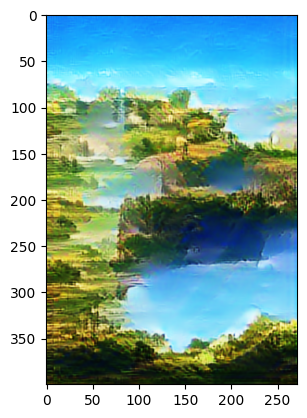

In [20]:
plt.imshow(np.squeeze(stylized_image))
plt.show()

# Saves the generated Image

In [ ]:
from tensorflow.keras.applications import vgg19

In [21]:
cv2.imwrite("C:\\Users\\muham\\Desktop\\Images\\stylized_image.jpg", cv2.cvtColor(np.squeeze(stylized_image) * 255, cv2.COLOR_BGR2RGB))

True